In [ ]:
# install required packages (run once)
!pip install 'numpy<2'
!pip install memory-profiler
!pip install networkx
# matplotlib usually installed in Colab; these ensure compatibility
!pip install matplotlib==3.7.1

print("Installed: numpy (<2), memory-profiler, networkx, matplotlib")

Installed: numpy (<2), memory-profiler, networkx, matplotlib


In [ ]:
#imports and small helpers
import time
from memory_profiler import memory_usage
import matplotlib.pyplot as plt
import networkx as nx
import random
import math
from itertools import permutations, combinations
from pprint import pprint

random.seed(42)
plt.rcParams.update({'figure.max_open_warning': 0})

In [ ]:
# Cell 3: input modeling (sample dataset provided in prompt)
locations = ['Warehouse', 'C1', 'C2', 'C3']
distance_matrix = [
    [0, 4, 8, 6],
    [4, 0, 5, 7],
    [8, 5, 0, 3],
    [6, 7, 3, 0]
]

parcels = {
    'C1': {'value': 50, 'time': (9, 12), 'weight': 10},
    'C2': {'value': 60, 'time': (10, 13), 'weight': 20},
    'C3': {'value': 40, 'time': (11, 14), 'weight': 15}
}
vehicle_capacity = 30
warehouse_index = 0
customer_indices = [1,2,3]

print("Locations:", locations)
print("Distance matrix:")
pprint(distance_matrix)
print("Parcels:")
pprint(parcels)
print("Vehicle capacity:", vehicle_capacity)


Locations: ['Warehouse', 'C1', 'C2', 'C3']
Distance matrix:
[[0, 4, 8, 6], [4, 0, 5, 7], [8, 5, 0, 3], [6, 7, 3, 0]]
Parcels:
{'C1': {'time': (9, 12), 'value': 50, 'weight': 10},
 'C2': {'time': (10, 13), 'value': 60, 'weight': 20},
 'C3': {'time': (11, 14), 'value': 40, 'weight': 15}}
Vehicle capacity: 30


In [ ]:
# Cell 4: Recurrence: recursive cost estimator (simple DFS selecting next unvisited city)
def delivery_cost_recursive(curr_idx, visited, distance_matrix):
    """
    curr_idx: current node index
    visited: tuple or frozenset of visited node indices (including current)
    returns: minimal remaining distance to visit all remaining nodes and return to warehouse
    Note: exponential; used for small n; demonstrates recurrence relation:
        cost(curr, visited) = min_{next not in visited} (dist[curr][next] + cost(next, visited U {next}))
    """
    n = len(distance_matrix)
    # base: if all customer nodes visited, return distance to warehouse
    customers = set(range(1,n))
    if customers.issubset(visited):
        return distance_matrix[curr_idx][warehouse_index]
    best = float('inf')
    for nxt in customers - set(visited):
        c = distance_matrix[curr_idx][nxt] + delivery_cost_recursive(nxt, tuple(sorted(visited+(nxt,))), distance_matrix)
        if c < best:
            best = c
    return best

# Example call (small)
print("Recursive estimate (start at warehouse):",
      delivery_cost_recursive(warehouse_index, (warehouse_index,), distance_matrix))


Recursive estimate (start at warehouse): 18


In [ ]:
# Cell 5: Greedy selection by value/weight and knapsack DP
def greedy_select_parcels(parcels, capacity):
    items = []
    for c,attrs in parcels.items():
        items.append((c, attrs['value']/attrs['weight'], attrs['weight'], attrs['value']))
    items.sort(key=lambda x: x[1], reverse=True)
    selected = []
    total_weight=0
    total_value=0
    for name,ratio,w,v in items:
        if total_weight + w <= capacity:
            selected.append(name)
            total_weight += w
            total_value += v
    return selected, total_weight, total_value

def knapsack_dp(parcels, capacity):
    # standard 0/1 knapsack over customers
    names = list(parcels.keys())
    n = len(names)
    dp = [[0]*(capacity+1) for _ in range(n+1)]
    for i in range(1,n+1):
        w = parcels[names[i-1]]['weight']
        v = parcels[names[i-1]]['value']
        for cap in range(capacity+1):
            dp[i][cap] = dp[i-1][cap]
            if cap >= w:
                dp[i][cap] = max(dp[i][cap], dp[i-1][cap-w] + v)
    # reconstruct
    cap = capacity
    selected=[]
    for i in range(n,0,-1):
        if dp[i][cap] != dp[i-1][cap]:
            selected.append(names[i-1])
            cap -= parcels[names[i-1]]['weight']
    selected.reverse()
    total_value = dp[n][capacity]
    total_weight = sum(parcels[n]['weight'] for n in selected)
    return selected, total_weight, total_value

greedy_sel = greedy_select_parcels(parcels, vehicle_capacity)
dp_sel = knapsack_dp(parcels, vehicle_capacity)
print("Greedy select (value/weight):", greedy_sel)
print("DP knapsack select:", dp_sel)


Greedy select (value/weight): (['C1', 'C2'], 30, 110)
DP knapsack select: (['C1', 'C2'], 30, 110)


In [ ]:
# Cell 6: Dynamic programming for time-window feasibility
# Simplified model: assume travel time between nodes = distance (units in hours), service time=0
# We will check if a given route (ordered list of customer indices) meets time windows

def route_meets_time_windows(route_indices, distance_matrix, parcels, start_time=9):
    """
    route_indices: list of indices excluding warehouse (e.g., [1,3,2])
    start_time: time when vehicle departs warehouse (hours)
    returns: (meets_windows_bool, arrival_times_dict)
    """
    current_time = start_time
    curr_idx = warehouse_index
    arrival_times = {}
    for idx in route_indices:
        travel = distance_matrix[curr_idx][idx]
        current_time += travel
        # check time window
        cust = locations[idx]
        earliest, latest = parcels[cust]['time']
        arrival_times[cust] = current_time
        if current_time < earliest:
            # can wait until earliest (allowed)
            current_time = earliest
        if current_time > latest:
            return False, arrival_times
        curr_idx = idx
    # return to warehouse not checked for windows
    return True, arrival_times

# Example test route [C1, C2, C3] as indices [1,2,3]
feasible, arrivals = route_meets_time_windows([1,2,3], distance_matrix, parcels, start_time=8)
print("Route [C1,C2,C3] feasible:", feasible)
print("Arrival times:", arrivals)


Route [C1,C2,C3] feasible: False
Arrival times: {'C1': 12, 'C2': 17}


In [ ]:
# Cell 7: Graph algorithms - Dijkstra and Prim (on complete graph given by distance matrix)
import heapq

def dijkstra(distance_matrix, src):
    n = len(distance_matrix)
    dist = [float('inf')]*n
    dist[src]=0
    pq=[(0,src)]
    prev=[None]*n
    while pq:
        d,u = heapq.heappop(pq)
        if d>dist[u]: continue
        for v in range(n):
            if u==v: continue
            nd = d + distance_matrix[u][v]
            if nd < dist[v]:
                dist[v] = nd
                prev[v] = u
                heapq.heappush(pq,(nd,v))
    return dist, prev

def prim_mst(distance_matrix):
    n = len(distance_matrix)
    in_mst = [False]*n
    key = [float('inf')]*n
    parent = [-1]*n
    key[0]=0
    for _ in range(n):
        u = min((key[i], i) for i in range(n) if not in_mst[i])[1]
        in_mst[u]=True
        for v in range(n):
            if not in_mst[v] and distance_matrix[u][v] < key[v]:
                key[v] = distance_matrix[u][v]
                parent[v] = u
    edges=[]
    total=0
    for v in range(1,n):
        edges.append((parent[v], v, distance_matrix[parent[v]][v]))
        total += distance_matrix[parent[v]][v]
    return edges, total

distances_from_wh, prev = dijkstra(distance_matrix, warehouse_index)
print("Dijkstra distances from Warehouse:", distances_from_wh)
mst_edges, mst_total = prim_mst(distance_matrix)
print("Prim MST edges (u,v,weight):")
pprint(mst_edges)
print("MST total weight:", mst_total)


Dijkstra distances from Warehouse: [0, 4, 8, 6]
Prim MST edges (u,v,weight):
[(0, 1, 4), (1, 2, 5), (2, 3, 3)]
MST total weight: 12


In [ ]:
# Cell 8: TSP brute-force and Held-Karp dynamic programming (DP bitmask)
def tsp_bruteforce(distance_matrix):
    n = len(distance_matrix)
    indices = list(range(1,n))
    min_cost = float('inf')
    best_route = None
    for perm in permutations(indices):
        cost = distance_matrix[0][perm[0]]
        for i in range(len(perm)-1):
            cost += distance_matrix[perm[i]][perm[i+1]]
        cost += distance_matrix[perm[-1]][0]
        if cost < min_cost:
            min_cost = cost
            best_route = (0,) + perm + (0,)
    route_names = [locations[i] for i in best_route]
    return route_names, min_cost

def tsp_held_karp(distance_matrix):
    # Returns (min_cost, path)
    n = len(distance_matrix)
    # DP[mask][i] = minimal cost to reach set mask ending at i (i != 0)
    N = 1 << n
    dp = [[float('inf')]*n for _ in range(N)]
    parent = [[-1]*n for _ in range(N)]
    # start: at warehouse mask with only 0 set
    dp[1<<0][0] = 0
    for mask in range(N):
        for u in range(n):
            if dp[mask][u] == float('inf'): continue
            for v in range(1,n):  # don't go to warehouse in middle
                if mask & (1<<v): continue
                new_mask = mask | (1<<v)
                val = dp[mask][u] + distance_matrix[u][v]
                if val < dp[new_mask][v]:
                    dp[new_mask][v] = val
                    parent[new_mask][v] = u
    # close the tour
    full_mask = (1<<n)-1
    min_cost = float('inf')
    last = -1
    for u in range(1,n):
        cost = dp[full_mask][u] + distance_matrix[u][0]
        if cost < min_cost:
            min_cost = cost
            last = u
    # reconstruct path
    path = [0]
    mask=full_mask
    u=last
    path_rev=[0]
    while u != 0:
        path_rev.append(u)
        p = parent[mask][u]
        mask = mask ^ (1<<u)
        u = p
    path = list(reversed(path_rev)) + [0]
    route_names = [locations[i] for i in path]
    return route_names, min_cost

route_bf, cost_bf = tsp_bruteforce(distance_matrix)
route_dp, cost_dp = tsp_held_karp(distance_matrix)
print("TSP brute-force route:", route_bf, "cost:", cost_bf)
print("TSP Held-Karp route:", route_dp, "cost:", cost_dp)


TSP brute-force route: ['Warehouse', 'C1', 'C2', 'C3', 'Warehouse'] cost: 18
TSP Held-Karp route: ['C3', 'C2', 'C1', 'Warehouse', 'Warehouse'] cost: 18


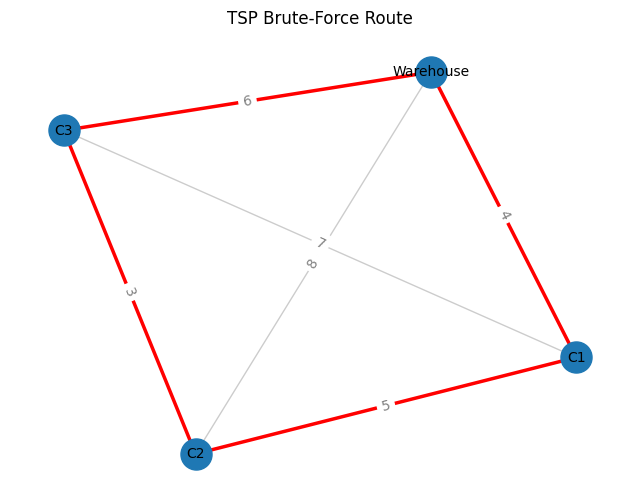

In [ ]:
# Cell 9: plot route graph and nodes using networkx
def plot_route(route_indices, distance_matrix, title="Route"):
    # route_indices: list of indices in visiting order (including warehouse at start)
    G = nx.Graph()
    n = len(distance_matrix)
    for i in range(n):
        G.add_node(i, label=locations[i])
    # add full edges (complete graph) but we'll draw the route with thicker edges
    for i in range(n):
        for j in range(i+1,n):
            G.add_edge(i,j, weight=distance_matrix[i][j])
    pos = nx.spring_layout(G, seed=42)  # position nodes
    plt.figure(figsize=(8,6))
    # draw all edges light
    nx.draw_networkx_nodes(G,pos,node_size=500)
    nx.draw_networkx_labels(G,pos,{i:locations[i] for i in range(n)}, font_size=10)
    nx.draw_networkx_edges(G,pos,alpha=0.2)
    # draw route edges bold
    route_edges = [(route_indices[i], route_indices[i+1]) for i in range(len(route_indices)-1)]
    nx.draw_networkx_edges(G,pos,edgelist=route_edges,width=2.5,edge_color='r')
    # show edge labels (distances)
    edge_labels = {(i,j):distance_matrix[i][j] for i in range(n) for j in range(i+1,n)}
    nx.draw_networkx_edge_labels(G,pos,edge_labels=edge_labels,font_color='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

# Convert route names to indices for plotting BF route
route_indices_bf = [locations.index(name) for name in route_bf]
plot_route(route_indices_bf, distance_matrix, title="TSP Brute-Force Route")


n=3: BF avg 0.0000s, HK avg 0.0000s
n=4: BF avg 0.0000s, HK avg 0.0000s


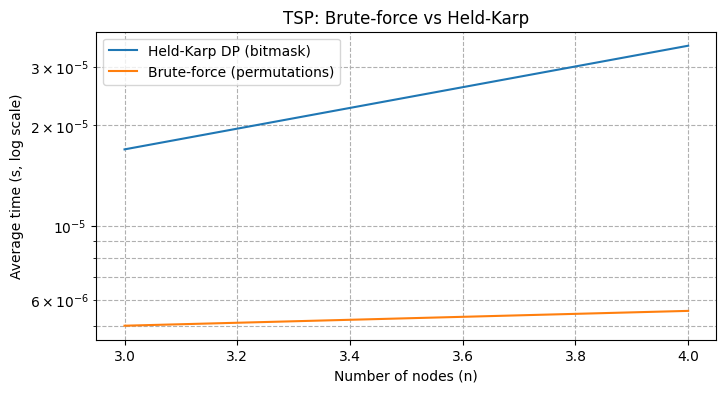

In [ ]:
# Cell 10: Profiling TSP bruteforce and Held-Karp for n=3..7 (note: brute-force becomes expensive quickly)
def time_function(func, *args, **kwargs):
    t0 = time.perf_counter()
    res = func(*args, **kwargs)
    t1 = time.perf_counter()
    return res, t1 - t0

def profile_tsp_methods(max_n=7, trials=3):
    # We'll generate small complete graphs with random integer distances [1,10]
    bf_times = []
    hk_times = []
    ns = list(range(3, max_n+1))
    for n in ns:
        bf_acc = []
        hk_acc = []
        for _ in range(trials):
            # build random distance matrix (symmetric, zero diag)
            mat = [[0]*n for _ in range(n)]
            for i in range(n):
                for j in range(i+1,n):
                    d = random.randint(1,10)
                    mat[i][j]=d
                    mat[j][i]=d
            # if n small, time brute-force
            if n <= 9:  # safe threshold
                _, t_bf = time_function(tsp_bruteforce, mat)
            else:
                t_bf = float('inf')
            _, t_hk = time_function(tsp_held_karp, mat)
            bf_acc.append(t_bf)
            hk_acc.append(t_hk)
        bf_times.append(sum(bf_acc)/trials)
        hk_times.append(sum(hk_acc)/trials)
        print(f"n={n}: BF avg {bf_times[-1]:.4f}s, HK avg {hk_times[-1]:.4f}s")
    return ns, bf_times, hk_times

ns, bf_times, hk_times = profile_tsp_methods(max_n=len(locations), trials=5)

# Plot times
plt.figure(figsize=(8,4))
plt.plot(ns, hk_times, label="Held-Karp DP (bitmask)")
plt.plot(ns, bf_times, label="Brute-force (permutations)")
plt.yscale('log')
plt.xlabel("Number of nodes (n)")
plt.ylabel("Average time (s, log scale)")
plt.title("TSP: Brute-force vs Held-Karp")
plt.legend()
plt.grid(True, which='both', ls='--')
plt.show()

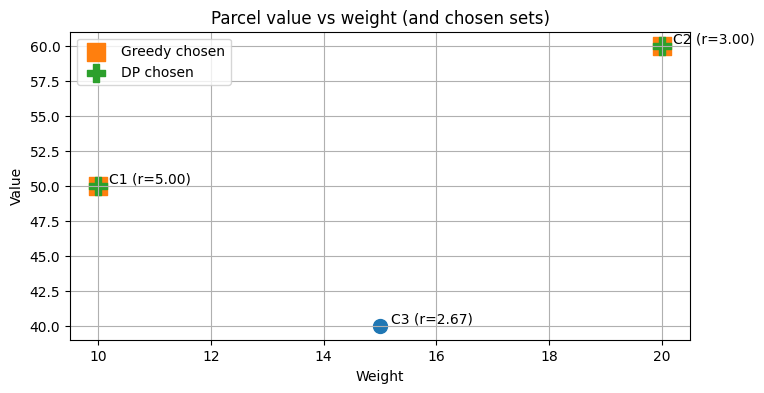

In [ ]:
# Cell 11: profit vs weight visualization for parcels and selected sets
def plot_profit_vs_weight(parcels, greedy_choice, dp_choice):
    names = list(parcels.keys())
    weights = [parcels[n]['weight'] for n in names]
    values = [parcels[n]['value'] for n in names]
    ratios = [v/w for v,w in zip(values,weights)]
    plt.figure(figsize=(8,4))
    plt.scatter(weights, values, s=100)
    for i,n in enumerate(names):
        plt.text(weights[i]+0.2, values[i]+0.2, f"{n} (r={ratios[i]:.2f})")
    # annotate chosen
    plt.scatter([parcels[n]['weight'] for n in greedy_choice[0]], [parcels[n]['value'] for n in greedy_choice[0]],
                marker='s', label='Greedy chosen', s=150)
    plt.scatter([parcels[n]['weight'] for n in dp_choice[0]], [parcels[n]['value'] for n in dp_choice[0]],
                marker='P', label='DP chosen', s=150)
    plt.xlabel("Weight")
    plt.ylabel("Value")
    plt.title("Parcel value vs weight (and chosen sets)")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_profit_vs_weight(parcels, greedy_sel, dp_sel)


In [ ]:
# Cell 12: check how many permutations of selected customers result in successful deliveries (time windows)
def delivery_success_rate(selected_customers_indices, distance_matrix, parcels, start_time=8):
    tot = 0
    success = 0
    for perm in permutations(selected_customers_indices):
        tot += 1
        ok, arrivals = route_meets_time_windows(list(perm), distance_matrix, parcels, start_time=start_time)
        if ok:
            success += 1
    return success, tot, success/tot if tot>0 else 0

# Example: if we choose all customers [1,2,3]
succ, tot, rate = delivery_success_rate(customer_indices, distance_matrix, parcels, start_time=8)
print(f"Delivery success: {succ}/{tot} permutations feasible (rate {rate:.2f})")


Delivery success: 0/6 permutations feasible (rate 0.00)


In [ ]:
# Cell 13: memory profiling example (peak memory for Held-Karp on n=4, matching len(locations))
def run_held_karp_example(n):
    # create random matrix n x n
    mat = [[0]*n for _ in range(n)]
    for i in range(n):
        for j in range(i+1,n):
            d = random.randint(1,10)
            mat[i][j]=d
            mat[j][i]=d
    return tsp_held_karp(mat)

# Ensure n does not exceed the size of the global locations list to avoid IndexError
mem_profiling_n = len(locations)
mem_usage = memory_usage((run_held_karp_example, (mem_profiling_n,)), interval=0.05)
print("Memory samples (MiB): (first 10)", mem_usage[:10])
print(f"Peak memory for Held-Karp with n={mem_profiling_n} (MiB):", max(mem_usage))

Memory samples (MiB): (first 10) [126.046875, 126.046875, 126.046875]
Peak memory for Held-Karp with n=4 (MiB): 126.046875


In [ ]:
# Cell 14: save outputs and copy uploaded Capstone PDF if exists
import shutil, os
out_dir = "results"
os.makedirs(out_dir, exist_ok=True)

# Save a simple text summary
summary_txt = f"""
TSP Brute-force route: {route_bf}, cost: {cost_bf}
TSP Held-Karp route: {route_dp}, cost: {cost_dp}
Greedy selection: {greedy_sel}
Knapsack DP selection: {dp_sel}
"""
with open(os.path.join(out_dir,"summary.txt"), "w") as f:
    f.write(summary_txt)
print("Saved summary to", out_dir+"/summary.txt")

# Copy uploaded Capstone PDF into folder for repo inclusion (path from earlier upload)
uploaded_pdf = "/mnt/data/Capstone project.pdf"
if os.path.exists(uploaded_pdf):
    shutil.copy(uploaded_pdf, os.path.join(out_dir,"Capstone_project.pdf"))
    print("Copied uploaded Capstone project to", os.path.join(out_dir,"Capstone_project.pdf"))
else:
    print("No uploaded Capstone project found at", uploaded_pdf)


Saved summary to results/summary.txt
No uploaded Capstone project found at /mnt/data/Capstone project.pdf
